**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. LightGBM

**LightGBM 장단점**

- XGB보다도 학습에 걸리는 시간이 훨씬 적으며 메모리 사용량도 상대적으로 적다.


- 카테고리형 피처를 자동 변환하고, 예측 성능 역시 큰 차이가 없다. 


- 데이터의 갯수가 적을 경우 과적합이 발생하기 쉽다. 


- 적은 데이터의 갯수에 대한 기준은 애매하지만 LightGBM의 공식 문서에서 10,000건 이하라고 기술하였다.

**트리 기반 알고리즘 특징**

- 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용한다.


- 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 깊이가 최소화 되며 오버피팅에 보다 강한 구조를 가진다. 


- 하지만 균형을 맞추기 위한 시간이 오래 걸리는 단점이 있다.

**LightGBM 특징**

- LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용한다.


- 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하여 깊이가 증가하고 비대칭적인 트리를 생성한다.


- 이렇게 생성된 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다는 것이 LightGBM 구현사상이다.

## 1.1 LightGBM 하이퍼 파라미터

LightGBM도 파이썬 래퍼, 사이킷런 래퍼가 있지만 여기선 사이킷런 기준으로 정리하였다.

**주요 파라미터**

- **n_estimators [default: 100]**: GBM과 XGB의 n_estimators와 같은 파라미터


- **learning_rate [defalut: 0.1]**: GBM과 XGB의 학습률(learning_rate)과 같은 파라미터

    일반적으로 n_estimators를 높이고 learning_rate를 낮추면 예측 성능이 향상하지만 마찬가지로 과적합 이슈 및 소요 시간 증가의 문제가 있다.
      
      
- **max_depth [default: 1]**: 트리 기반 알고리즘의 max_depth와 같다. 0보다 작은 값을 지정하면 깊이 제한이 없다.

    LightGBM은 Leaf Wise 방식이므로 깊이가 상대적으로 더 깊다.
              

- **min_child_samples [default: 20]**: 결정 트리의 min_samples_leaf와 같은 파라미터로 리프 노드가 되기 위해 최소한으로 필요한 샘플 수
                       
                       
- **num_leaves [default: 31]**: 하나의 트리가 가질 수 있는 최대 리프 개수


- **boosting [default: gbdt]**: 부스팅의 트리를 생성하는 알고리즘을 지정하며 gbdt는 일반적인 그래디언트 부스팅 결정 트리이며 rf는 랜덤 포레스트이다.


- **subsample [default: 1]**: GBM과 XGB의 subsample과 같은 파라미터


- **colsample_bytree [default: 1]**: XGB의 colsample_bytree와 같은 파라미터로 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율


- **reg_lambda [default: 0]**: XGB의 reg_lambda와 같은 파라미터로 L2 regulation 제어를 위한 값이다.

    피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.
    
    
- **reg_alpha [default: 0]**: XGB의 reg_alpha와 같은 파라미터로 L1 regulation 제어를 위한 값이다.

    피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.

**학습 태스크 파라미터**

- **objective**: 최솟값을 가져야할 손실함수를 정의한다. XGB의 objective 파라미터와 동일하다.

## 1.2 위스콘신 유방암 예측

**LightGBM 학습/예측**

In [7]:
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
lgbm_wrapper = LGBMClassifier(n_estimators=4000)
lgbm_wrapper.fit(X_train, y_train,
                 # 조기 중단 파라미터
                 early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                 verbose=True)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

LGBMClassifier(n_estimators=4000)

- 조기 중단으로 145번 반복까지만 수행하고 학습을 종료하였다.

**LightGBM 예측/평가**

In [8]:
# 3장에서 사용한 성능 평가 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [9]:
# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC: 0.9905


- 앞서 XGB방법으로 평가한 파일과 비교하면 전체적인 성능은 낮게 나오지만 train과 test 데이터 크기가 작아서 알고리즘 간 성능 비교는 큰 의미가 없다.

**LightGBM 피처별 중요도**

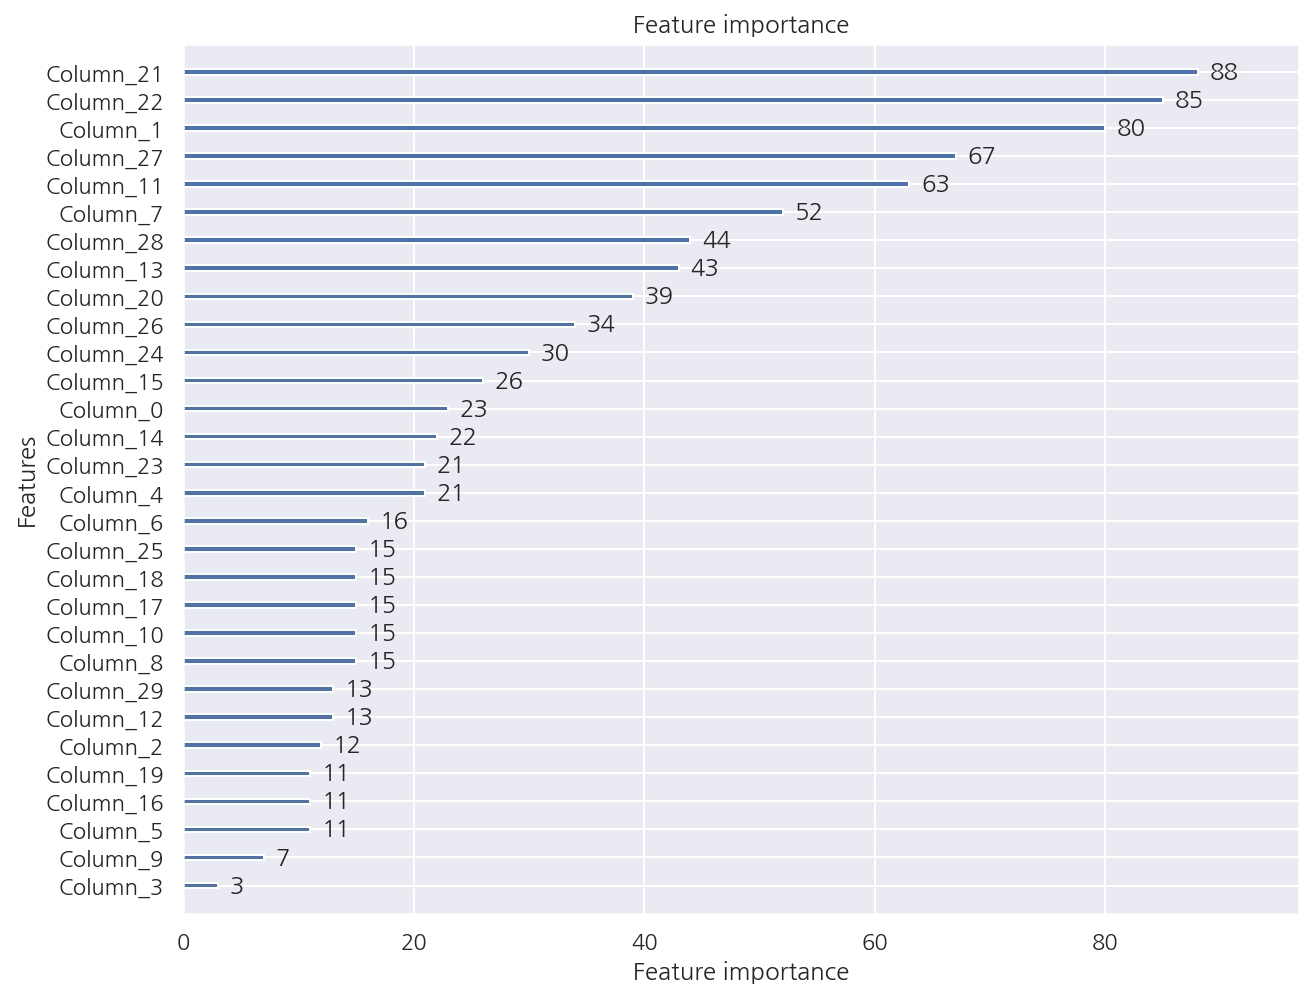

In [12]:
from lightgbm import plot_importance

plot_importance(lgbm_wrapper)
plt.show()

- LightGBM 역시 XGB와 마찬가지로 피처별 중요도 시각화 함수가 내장되어 있으며 명령어 역시 동일하다.